In [1]:
!pip install transformers

In [2]:
!pip install -q datasets

In [3]:
!pip install pyyaml==5.1
!pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html


In [4]:
!sudo apt install tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [5]:
from datasets import load_dataset 

datasets = load_dataset("katanaml/cord")

Reusing dataset cord (/root/.cache/huggingface/datasets/katanaml___cord/cord/1.0.0/fa0960248a7d19cf19675785d5d3dd9eab83b4aea9274b97943d534be56d8a91)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
labels = datasets['train'].features['ner_tags'].feature.names
print(labels)

['O', 'I-menu.cnt', 'I-menu.discountprice', 'I-menu.nm', 'I-menu.num', 'I-menu.price', 'I-menu.sub_cnt', 'I-menu.sub_nm', 'I-menu.sub_price', 'I-menu.unitprice', 'I-sub_total.discount_price', 'I-sub_total.etc', 'I-sub_total.service_price', 'I-sub_total.subtotal_price', 'I-sub_total.tax_price', 'I-total.cashprice', 'I-total.changeprice', 'I-total.creditcardprice', 'I-total.emoneyprice', 'I-total.menuqty_cnt', 'I-total.menutype_cnt', 'I-total.total_etc', 'I-total.total_price']


In [7]:
example = datasets["validation"][1]
print(example.keys())

dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image_path'])


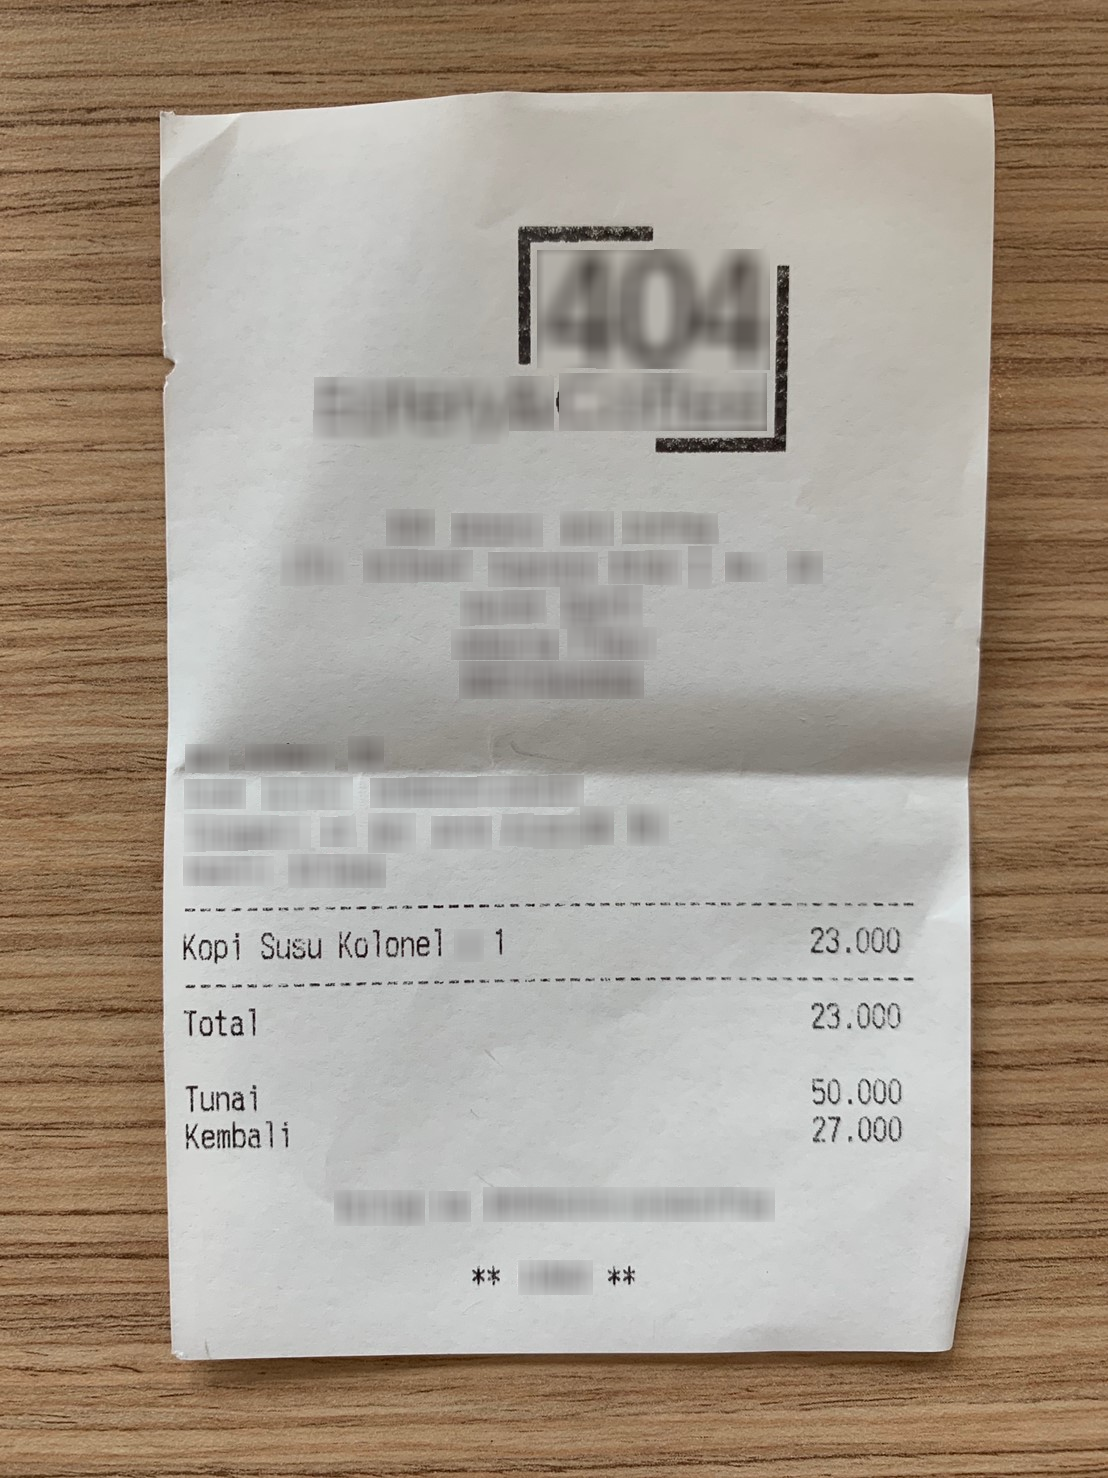

In [8]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(example['image_path'])
image = image.convert("RGB")

image

In [9]:
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

encoding = processor(image, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])


In [10]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for k,v in encoding.items():
  encoding[k] = v.to(device)

In [11]:
from transformers import LayoutLMv2ForTokenClassification

# load the fine-tuned model from the hub
model = LayoutLMv2ForTokenClassification.from_pretrained("katanaml/layoutlmv2-finetuned-cord")
id2label = model.config.id2label
model.to(device)

# forward pass
outputs = model(**encoding)
print(outputs.logits.shape)

/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:779: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:789: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

torch.Size([1, 14, 23])


In [12]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = image.size

In [13]:
processor.tokenizer.batch_decode(encoding.input_ids)

['[CLS] 23. 000 50. 000 kembali 27. 000 [SEP]']

In [14]:
import numpy as np

is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

In [15]:
print(true_predictions)

['I-menu.cnt', 'I-total.total_price', 'I-total.cashprice', 'I-total.changeprice', 'I-total.changeprice', 'I-menu.cnt']


In [16]:
print(true_boxes)

[[0.0, 0.0, 0.0, 0.0], [811.0559999999999, 1002.0840000000001, 899.696, 1028.6879999999999], [811.0559999999999, 1078.94, 900.804, 1102.588], [185.036, 1120.324, 286.97200000000004, 1148.406], [812.164, 1115.89, 900.804, 1141.016], [1108.0, 1478.0, 1108.0, 1478.0]]


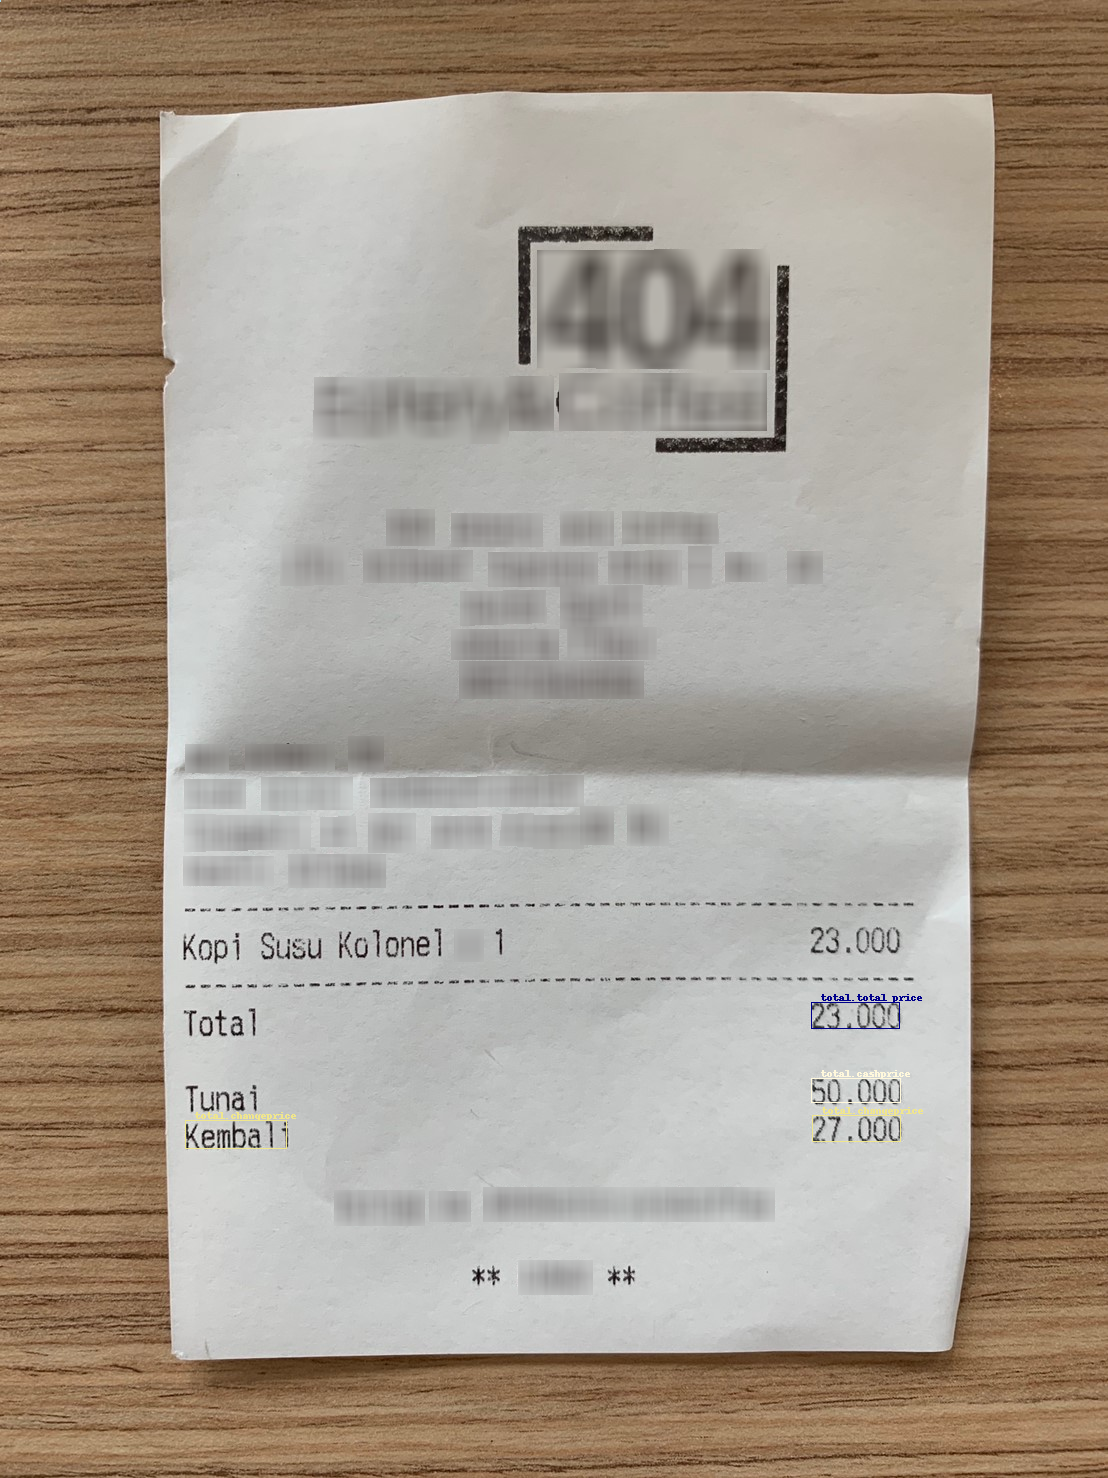

In [17]:
from PIL import ImageDraw
import numpy as np
import PIL

image = Image.open(example['image_path'])
image = image.convert("RGB")

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'o'
    return label

label_ints = np.random.randint(0,len(PIL.ImageColor.colormap.items()),30)

label_color_pil = [k for k,_ in PIL.ImageColor.colormap.items()]
	
label_color = [label_color_pil[i] for i in label_ints]
label2color = {}
for k,v in id2label.items():
  if v[2:] == '':
    label2color['o']=label_color[k]
  else:
    label2color[v[2:]]=label_color[k]

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

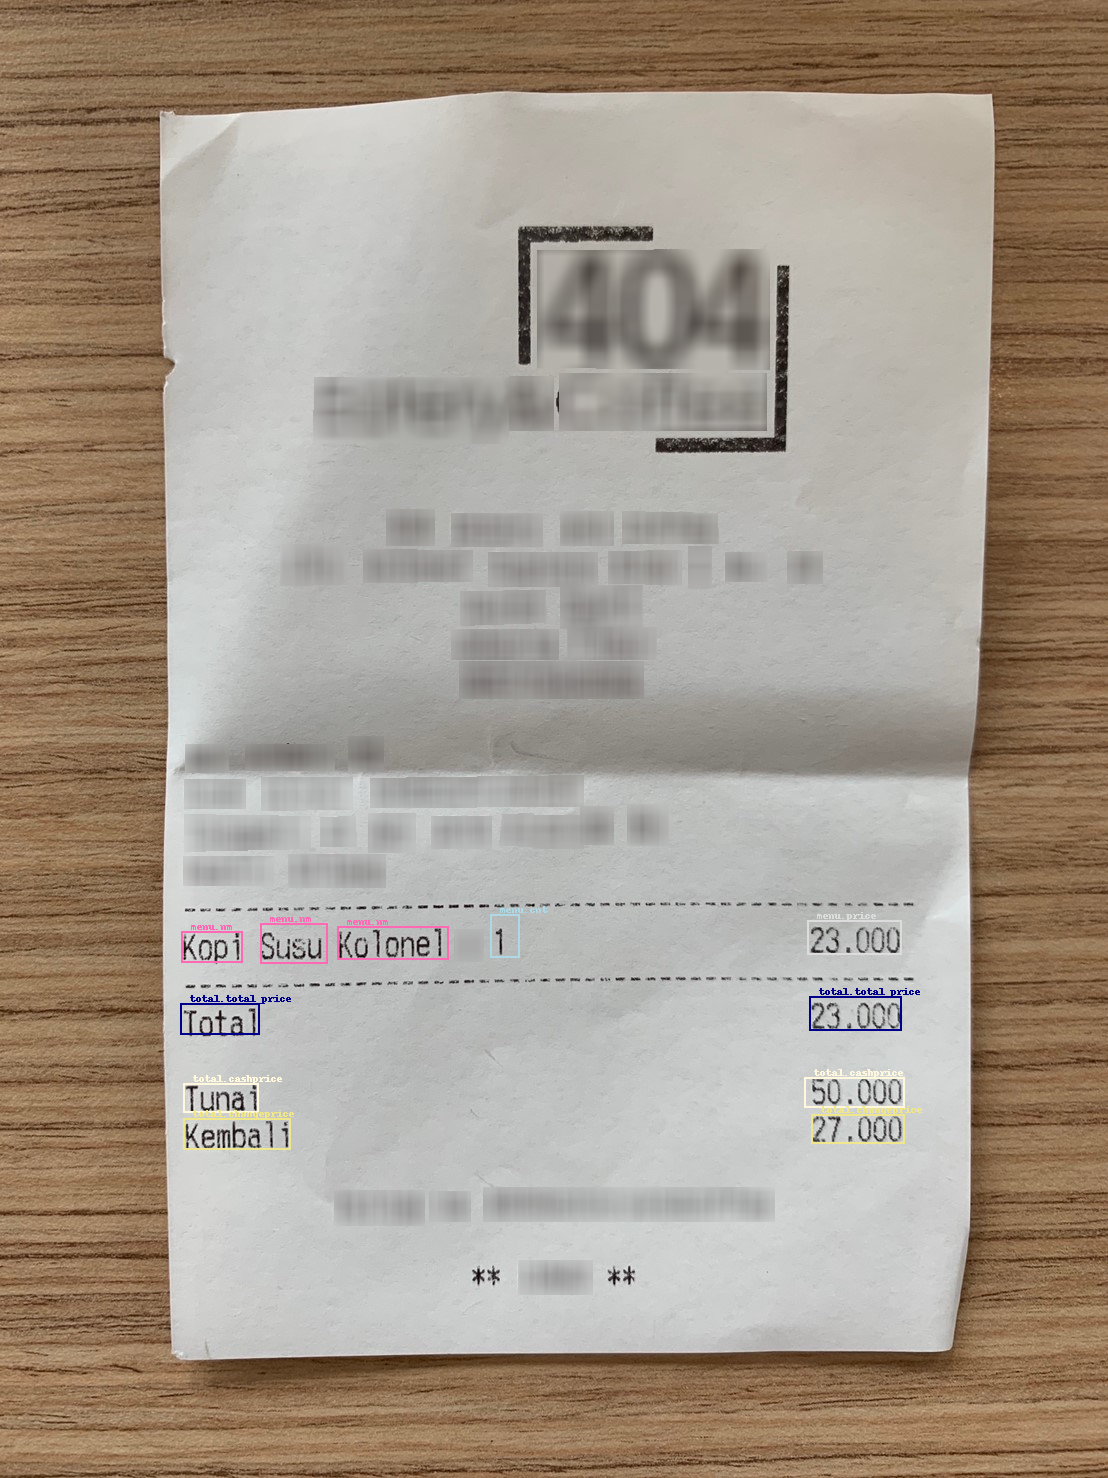

In [18]:
image = Image.open(example['image_path'])
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['words'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image